📊 Estadísticas descriptivas:
       value_mean  value_std  value_min  value_max  value_last  \
count    5.000000   5.000000   5.000000   5.000000    5.000000   
mean    25.034048   2.890536  20.010000  29.992000   22.464000   
std      0.061607   0.030608   0.007071   0.010954    3.323045   
min     24.959950   2.869802  20.000000  29.980000   20.550000   
25%     24.981505   2.870850  20.010000  29.980000   20.720000   
50%     25.044879   2.872303  20.010000  30.000000   21.030000   
75%     25.084648   2.898917  20.010000  30.000000   21.660000   
max     25.099260   2.940808  20.020000  30.000000   28.360000   

       timestamp_epoch_max  
count         5.000000e+00  
mean          1.755527e+09  
std           4.786020e+00  
min           1.755527e+09  
25%           1.755527e+09  
50%           1.755527e+09  
75%           1.755527e+09  
max           1.755527e+09  


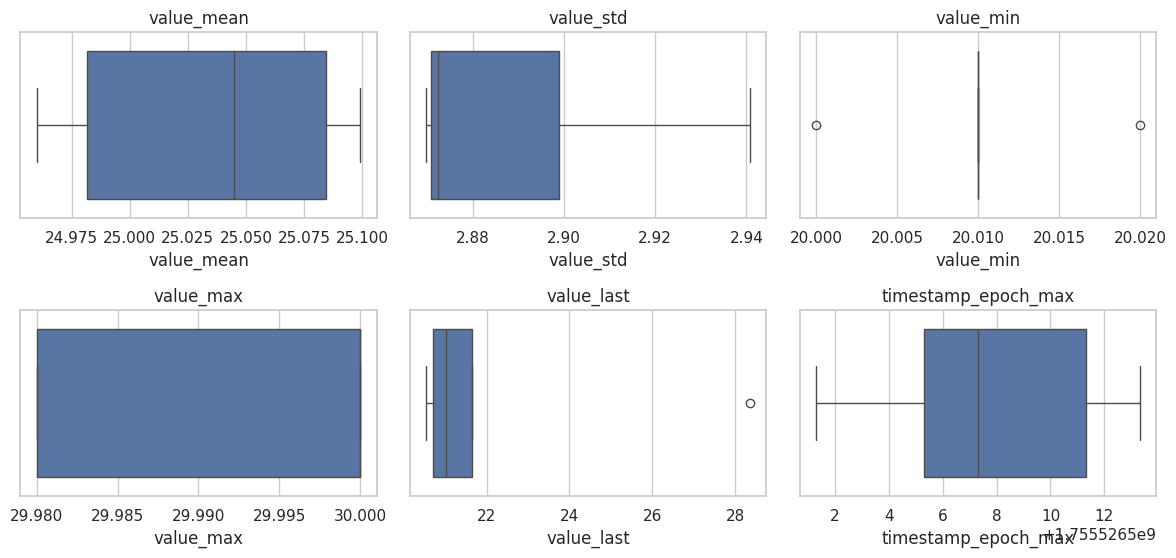


🔍 Detección no supervisada:
iso_anomaly
0    4
1    1
Name: count, dtype: int64

🎯 Predicciones combinadas:
0    4
1    1
Name: count, dtype: int64

⚠️ No hay etiquetas reales para evaluación

🔤 Etiquetas decodificadas:
predicted_label
0    4
1    1
Name: count, dtype: int64


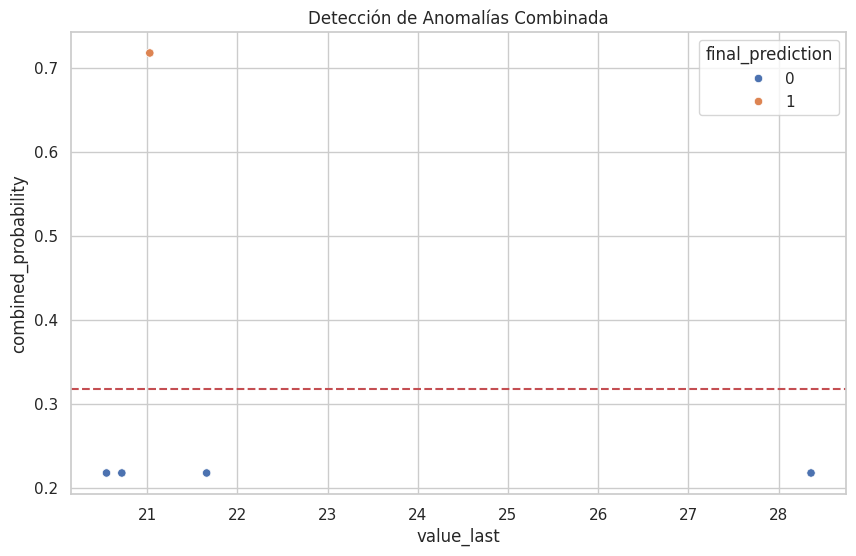


🔍 CONCLUSIONES Y RECOMENDACIONES:
1. DATOS INSUFICIENTES: Solo 5 registros son insuficientes para aprendizaje supervisado
2. ESTRATEGIA ACTUAL:
   - Modelo existente (supervisado)
   - IsolationForest (no supervisado)
3. ACCIONES REQUERIDAS:
   - Recolectar más datos (idealmente 100+ registros)
   - Implementar monitoreo continuo
   - Validar con expertos de dominio

💾 Resultados guardados en:
- Predictions: /home/user/proyecto-nitro/notebooks/data/enhanced_predictions.csv
- Reportes: /home/user/proyecto-nitro/notebooks/reports/


In [13]:

# --- CONFIGURACIÓN ---
import pandas as pd
import numpy as np
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report
import mlflow

# Ajustes de estilo
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Configura paths
DATA_PATH = '/home/user/proyecto-nitro/notebooks/data/'
MODELS_PATH = '/home/user/proyecto-nitro/notebooks/models/'
REPORTS_PATH = '/home/user/proyecto-nitro/notebooks/reports/'

# --- CARGA DE DATOS Y MODELOS ---
df = pd.read_csv(os.path.join(DATA_PATH, 'processed_features.csv'))
scaler = joblib.load(os.path.join(MODELS_PATH, 'scaler.pkl'))
prev_model = joblib.load(os.path.join(MODELS_PATH, 'sensor_model_rf_robust.pkl'))
label_encoder = joblib.load(os.path.join(MODELS_PATH, 'label_encoder.pkl'))

print("📊 Estadísticas descriptivas:")
print(df.describe())

# --- VISUALIZACIÓN DE DISTRIBUCIONES ---
plt.figure(figsize=(12, 8))
numeric_cols = df.select_dtypes(include=np.number).columns
for i, col in enumerate(numeric_cols):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x=df[col])
    plt.title(col)
plt.tight_layout()
plt.savefig(os.path.join(REPORTS_PATH, 'boxplots.png'))
plt.show()

# --- PREPARACIÓN DE FEATURES PARA ML ---
# Obtener características requeridas por todos los componentes
required_features = list(set(prev_model.feature_names_in_).union(set(scaler.feature_names_in_)))

# Crear columnas faltantes con ceros
for col in required_features:
    if col not in df.columns:
        df[col] = 0

# Alinear datos para el modelo y el scaler
X_model = df[prev_model.feature_names_in_]
X_scaler = df[scaler.feature_names_in_]

# Escalar
X_scaled = scaler.transform(X_scaler)

# --- DETECCIÓN NO SUPERVISADA DE ANOMALÍAS ---
iso_forest = IsolationForest(contamination=0.2, random_state=42)
iso_pred = iso_forest.fit_predict(X_scaled)
df['iso_anomaly'] = np.where(iso_pred == -1, 1, 0)

print("\n🔍 Detección no supervisada:")
print(df['iso_anomaly'].value_counts())

# --- ENSEMBLE CON MODELO EXISTENTE ---
if hasattr(prev_model, 'predict_proba'):
    prev_proba = prev_model.predict_proba(X_model)[:, 1]
else:
    prev_proba = prev_model.predict(X_model)

# Convertir IsolationForest output -1,1 a 0,1
iso_proba = (1 - (iso_pred + 1)/2)

# Combinar predicciones (50% cada enfoque)
combined_proba = 0.5 * prev_proba + 0.5 * iso_proba

# Umbral percentil 80
threshold = np.percentile(combined_proba, 80)
final_pred = (combined_proba > threshold).astype(int)

print("\n🎯 Predicciones combinadas:")
print(pd.Series(final_pred).value_counts())

# --- EVALUACIÓN ---
if 'anomaly' in df.columns:
    print("\n📝 Evaluación contra etiquetas reales:")
    print(classification_report(df['anomaly'], final_pred, zero_division=0))
else:
    print("\n⚠️ No hay etiquetas reales para evaluación")

# --- DECODIFICAR ETIQUETAS SI ES NECESARIO ---
if hasattr(label_encoder, 'classes_'):
    try:
        df['predicted_label'] = label_encoder.inverse_transform(final_pred)
        print("\n🔤 Etiquetas decodificadas:")
        print(df['predicted_label'].value_counts())
    except ValueError as e:
        print(f"\n⚠️ Error al decodificar etiquetas: {e}")

# --- GUARDADO DE RESULTADOS ---
results = pd.DataFrame({
    'sensor_id': df['sensor_id'],
    'value_last': df['value_last'],
    'unsupervised_anomaly': df['iso_anomaly'],
    'model_probability': prev_proba,
    'combined_probability': combined_proba,
    'final_prediction': final_pred
})

# Añadir etiquetas decodificadas si existen
if 'predicted_label' in df.columns:
    results['predicted_label'] = df['predicted_label']

results.to_csv(os.path.join(DATA_PATH, 'enhanced_predictions.csv'), index=False)

# --- VISUALIZACIÓN FINAL ---
plt.figure(figsize=(10, 6))
sns.scatterplot(x='value_last', y='combined_probability', hue='final_prediction', data=results)
plt.axhline(y=threshold, color='r', linestyle='--')
plt.title("Detección de Anomalías Combinada")
plt.savefig(os.path.join(REPORTS_PATH, 'combined_anomalies.png'))
plt.show()

# --- RECOMENDACIONES FINALES ---
print("\n🔍 CONCLUSIONES Y RECOMENDACIONES:")
print("1. DATOS INSUFICIENTES: Solo 5 registros son insuficientes para aprendizaje supervisado")
print("2. ESTRATEGIA ACTUAL:")
print("   - Modelo existente (supervisado)")
print("   - IsolationForest (no supervisado)")
print("3. ACCIONES REQUERIDAS:")
print("   - Recolectar más datos (idealmente 100+ registros)")
print("   - Implementar monitoreo continuo")
print("   - Validar con expertos de dominio")

print("\n💾 Resultados guardados en:")
print(f"- Predictions: {os.path.join(DATA_PATH, 'enhanced_predictions.csv')}")
print(f"- Reportes: {REPORTS_PATH}")

